<a href="https://colab.research.google.com/github/Y326s/ECE6397HW/blob/main/CNN_Beginner_Assignment_YS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Programming Assignment: Introduction to Convolutional Neural Networks

## Learning Objectives
By the end of this assignment, you will be able to:
1. **Understand the basic concepts** of Convolutional Neural Networks
2. **Implement CNN layers** from scratch using PyTorch
3. **Visualize how CNNs learn** features at different layers
4. **Compare CNN vs Fully Connected** networks on image data

---


## Part 1: Setup and Imports

Let's start by importing the necessary libraries and setting up our environment.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Setup complete!")


Using device: cuda
✓ Setup complete!


## Part 2: Understanding Convolutional Layers

**Key Concept**: Convolutional layers apply filters (kernels) to detect patterns like edges, textures, and shapes.

Let's start by understanding what convolution does:


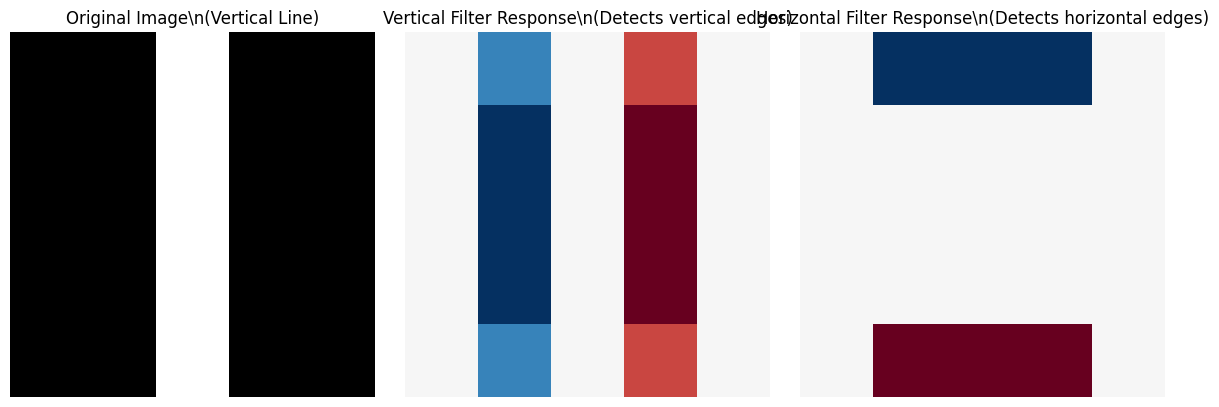

🔍 Key Insight: Different filters detect different patterns!
   - Vertical filter: Strong response to vertical lines
   - Horizontal filter: Strong response to horizontal lines


In [ ]:
# Let's create a simple example to understand convolution
def visualize_convolution():
    # Create a simple 5x5 image with a vertical line
    image = torch.zeros(1, 1, 5, 5)
    image[0, 0, :, 2] = 1  # Vertical line in the middle

    # Create different filters
    vertical_filter = torch.tensor([[[[-1, 0, 1],
                                      [-1, 0, 1],
                                      [-1, 0, 1]]]], dtype=torch.float32)

    horizontal_filter = torch.tensor([[[[-1, -1, -1],
                                        [0, 0, 0],
                                        [1, 1, 1]]]], dtype=torch.float32)

    # Apply convolution
    conv_vertical = F.conv2d(image, vertical_filter, padding=1)
    conv_horizontal = F.conv2d(image, horizontal_filter, padding=1)

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(image[0, 0].numpy(), cmap='gray')
    axes[0].set_title('Original Image\\n(Vertical Line)')
    axes[0].axis('off')

    axes[1].imshow(conv_vertical[0, 0].numpy(), cmap='RdBu')
    axes[1].set_title('Vertical Filter Response\\n(Detects vertical edges)')
    axes[1].axis('off')

    axes[2].imshow(conv_horizontal[0, 0].numpy(), cmap='RdBu')
    axes[2].set_title('Horizontal Filter Response\\n(Detects horizontal edges)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print("Key Observation: Different filters detect different patterns!")
    print("   - Vertical filter: Strong response to vertical lines")
    print("   - Horizontal filter: Strong response to horizontal lines")

visualize_convolution()


## Part 3: Loading MNIST Dataset

MNIST is simple, well-understood, and fast to train for CNN.


100%|██████████| 9.91M/9.91M [00:00<00:00, 60.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.23MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.5MB/s]


Training samples: 60000
Test samples: 10000
Batch size: 64
Number of batches per epoch: 938
\nSample MNIST images:


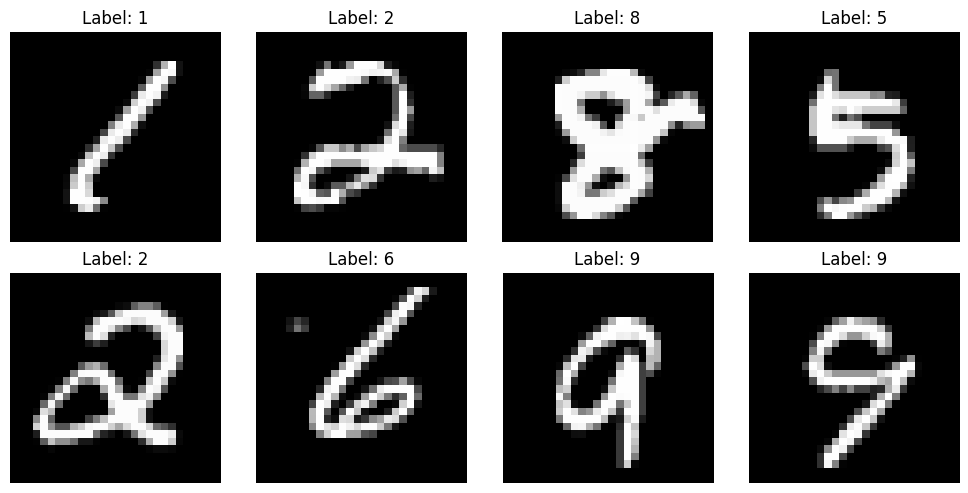

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of batches per epoch: {len(train_loader)}")

# Visualize some samples
def show_samples(loader, num_samples=8):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for i in range(num_samples):
        row, col = i // 4, i % 4
        axes[row, col].imshow(images[i][0].numpy(), cmap='gray')
        axes[row, col].set_title(f'Label: {labels[i].item()}')
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()

print("\\nSample MNIST images:")
show_samples(train_loader)


## Part 4: Building Our First CNN

Let's build a simple CNN step by step to understand each component.


In [ ]:
class SimpleCNN(nn.Module):
    """
    A simple CNN for MNIST classification.
    Architecture: Conv -> ReLU -> MaxPool -> Conv -> ReLU -> MaxPool -> FC
    """
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 64 channels * 7 * 7 = 3136
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))  # 1x28x28 -> 32x28x28
        x = self.pool1(x)          # 32x28x28 -> 32x14x14

        # Second conv block
        x = F.relu(self.conv2(x))  # 32x14x14 -> 64x14x14
        x = self.pool2(x)          # 64x14x14 -> 64x7x7

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # 64x7x7 -> 3136

        # Fully connected layers
        x = F.relu(self.fc1(x))    # 3136 -> 128
        x = self.dropout(x)        # Apply dropout
        x = self.fc2(x)            # 128 -> 10

        return x

# Create and test our CNN
model = SimpleCNN()
model.to(device)

# Test with a sample batch
sample_batch = next(iter(train_loader))
images, labels = sample_batch
images = images.to(device)

with torch.no_grad():
    output = model(images)
    predictions = torch.argmax(output, dim=1)

print(f"Input shape: {images.shape}")
print(f"Output shape: {output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Sample predictions: {predictions[:5].cpu().numpy()}")
print(f"Actual labels: {labels[:5].numpy()}")
print("SimpleCNN working correctly!")


Input shape: torch.Size([64, 1, 28, 28])
Output shape: torch.Size([64, 10])
Number of parameters: 421,642
Sample predictions: [9 3 3 3 3]
Actual labels: [6 2 4 6 8]
✓ SimpleCNN working correctly!


## Part 5: Training Our CNN

Now let's train our CNN and see how it learns!


In [ ]:
def train_model(model, train_loader, test_loader, epochs=5, learning_rate=0.001):
    """
    Train the CNN model
    """
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Track training history
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Test phase
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_acc = 100 * test_correct / test_total
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%')

    return train_losses, train_accuracies, test_accuracies

# Train the model
print("Starting training...")
train_losses, train_accs, test_accs = train_model(model, train_loader, test_loader, epochs=5)
print("\\n Training complete!")


Starting training...
Epoch [1/5], Loss: 0.2201, Train Acc: 93.21%, Test Acc: 98.45%
Epoch [2/5], Loss: 0.0790, Train Acc: 97.67%, Test Acc: 98.96%
Epoch [3/5], Loss: 0.0600, Train Acc: 98.26%, Test Acc: 98.97%
Epoch [4/5], Loss: 0.0489, Train Acc: 98.56%, Test Acc: 99.16%
Epoch [5/5], Loss: 0.0370, Train Acc: 98.87%, Test Acc: 99.12%
\n✓ Training complete!


## Part 6: Visualizing Training Progress

Let's plot the training curves to see how our model learned.


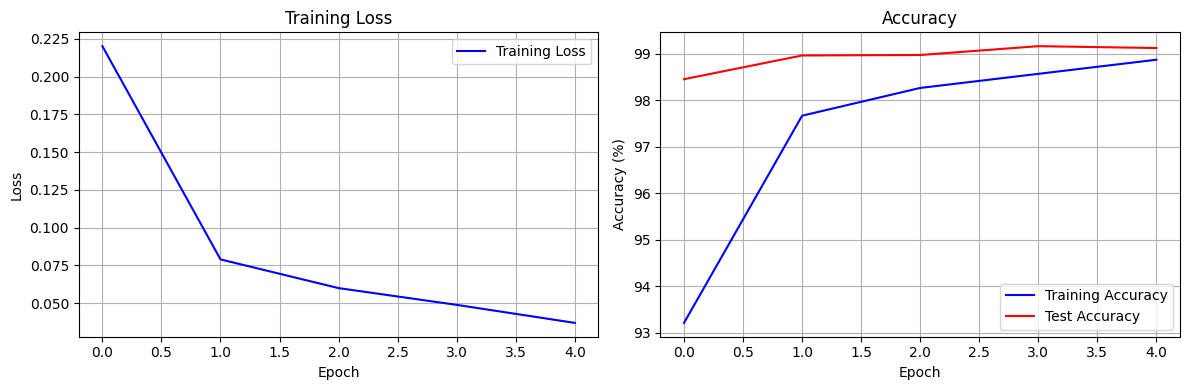

Final training accuracy: 98.87%
Final test accuracy: 99.12%


In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
ax1.plot(train_losses, 'b-', label='Training Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(train_accs, 'b-', label='Training Accuracy')
ax2.plot(test_accs, 'r-', label='Test Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final training accuracy: {train_accs[-1]:.2f}%")
print(f"Final test accuracy: {test_accs[-1]:.2f}%")


## Part 7: Understanding What CNNs Learn

Let's visualize the filters and feature maps to understand what our CNN learned.


Visualizing learned filters...


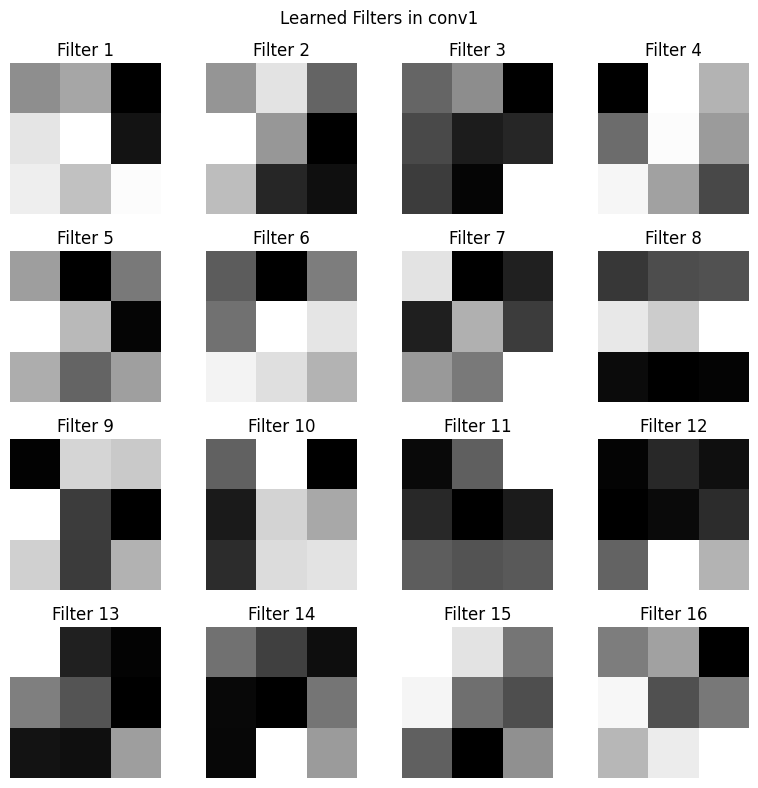

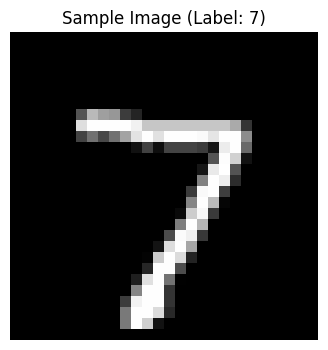

Visualizing feature maps...


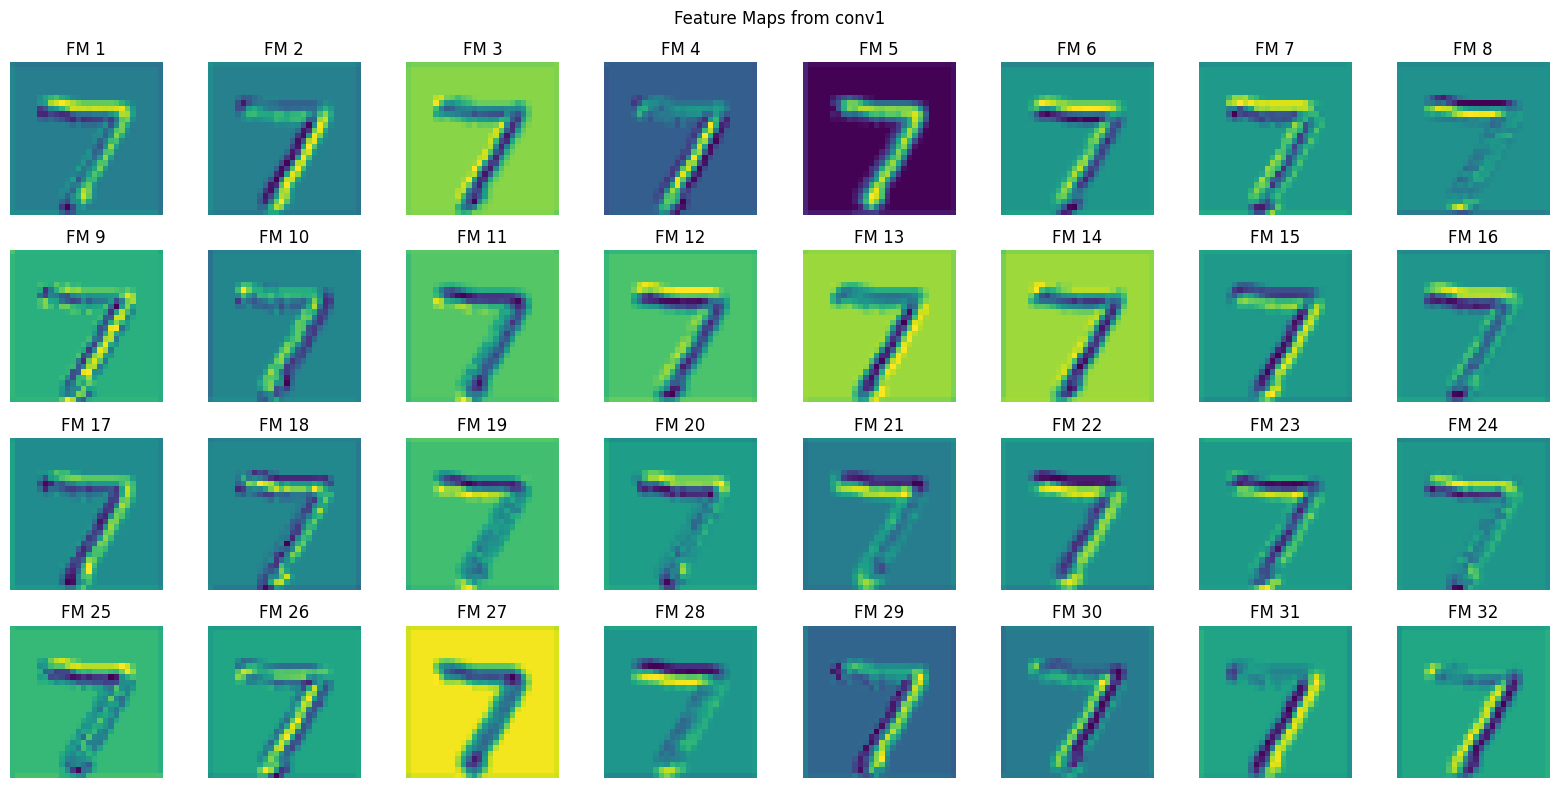

In [ ]:
def visualize_filters(model, layer_name='conv1'):
    """
    Visualize the learned filters in the first convolutional layer
    """
    # Get the first convolutional layer
    conv_layer = getattr(model, layer_name)
    filters = conv_layer.weight.data.cpu().numpy()

    # Plot first 16 filters
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        row, col = i // 4, i % 4
        filter_img = filters[i, 0]  # First channel (grayscale)

        # Normalize for visualization
        filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min() + 1e-8)

        axes[row, col].imshow(filter_img, cmap='gray')
        axes[row, col].set_title(f'Filter {i+1}')
        axes[row, col].axis('off')

    plt.suptitle(f'Learned Filters in {layer_name}')
    plt.tight_layout()
    plt.show()

def visualize_feature_maps(model, sample_image, layer_name='conv1'):
    """
    Visualize feature maps for a sample image
    """
    model.eval()

    # Hook to capture intermediate outputs
    activations = {}
    def hook_fn(module, input, output):
        activations[layer_name] = output.detach()

    # Register hook
    conv_layer = getattr(model, layer_name)
    hook = conv_layer.register_forward_hook(hook_fn)

    # Forward pass
    with torch.no_grad():
        _ = model(sample_image.unsqueeze(0).to(device))

    # Remove hook
    hook.remove()

    # Visualize feature maps
    feature_maps = activations[layer_name].cpu().numpy()[0]  # First sample

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(32):  # Show first 32 feature maps
        row, col = i // 8, i % 8
        if i < feature_maps.shape[0]:
            axes[row, col].imshow(feature_maps[i], cmap='viridis')
            axes[row, col].set_title(f'FM {i+1}')
        axes[row, col].axis('off')

    plt.suptitle(f'Feature Maps from {layer_name}')
    plt.tight_layout()
    plt.show()

# Visualize learned filters
print("Visualizing learned filters...")
visualize_filters(model, 'conv1')

# Get a sample image
sample_images, sample_labels = next(iter(test_loader))
sample_image = sample_images[0]

# Show original image
plt.figure(figsize=(4, 4))
plt.imshow(sample_image[0].numpy(), cmap='gray')
plt.title(f'Sample Image (Label: {sample_labels[0].item()})')
plt.axis('off')
plt.show()

# Visualize feature maps
print("Visualizing feature maps...")
visualize_feature_maps(model, sample_image, 'conv1')


## Part 8: CNN vs Fully Connected Network Comparison

Let's compare our CNN with a traditional fully connected network to see the difference.


Model Comparison:
CNN parameters: 421,642
FC parameters: 535,818
\nTraining CNN...
Epoch [1/3], Loss: 0.2135, Train Acc: 93.42%, Test Acc: 98.65%
Epoch [2/3], Loss: 0.0830, Train Acc: 97.56%, Test Acc: 98.90%
Epoch [3/3], Loss: 0.0613, Train Acc: 98.14%, Test Acc: 98.95%
\nTraining Fully Connected Network...
Epoch [1/3], Loss: 0.3325, Train Acc: 89.78%, Test Acc: 96.06%
Epoch [2/3], Loss: 0.1833, Train Acc: 94.55%, Test Acc: 96.82%
Epoch [3/3], Loss: 0.1583, Train Acc: 95.30%, Test Acc: 97.18%
\n=== Comparison Results ===
CNN - Final Test Accuracy: 98.95%
FC  - Final Test Accuracy: 97.18%


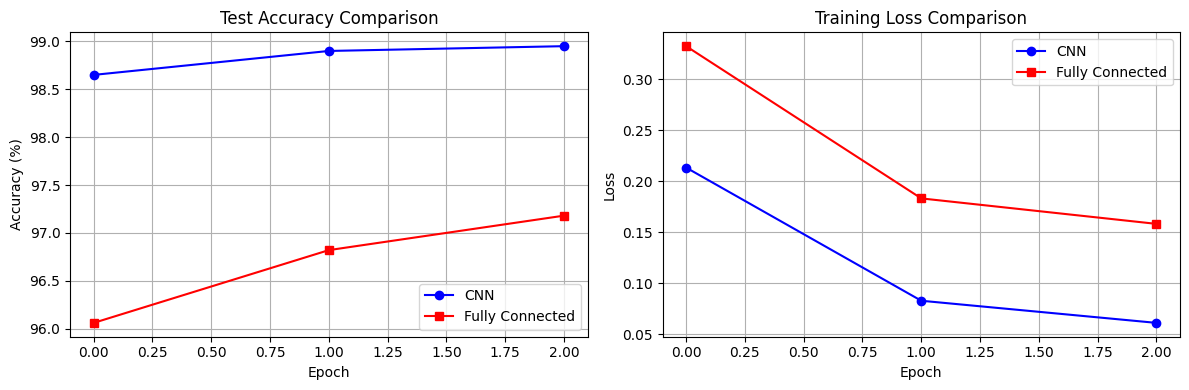

\n🔍 Key Insights:
1. CNNs are more efficient (fewer parameters)
2. CNNs often achieve better accuracy on image data
3. CNNs learn spatial patterns automatically


In [ ]:
class FullyConnectedNet(nn.Module):
    """
    A fully connected network for comparison
    """
    def __init__(self, num_classes=10):
        super(FullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Create both models and move to device
cnn_model = SimpleCNN().to(device)
fc_model = FullyConnectedNet().to(device)

print("Model Comparison:")
print(f"CNN parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")
print(f"FC parameters: {sum(p.numel() for p in fc_model.parameters()):,}")

# Train both models
print("\\nTraining CNN...")
cnn_losses, cnn_train_accs, cnn_test_accs = train_model(cnn_model, train_loader, test_loader, epochs=3)

print("\\nTraining Fully Connected Network...")
fc_losses, fc_train_accs, fc_test_accs = train_model(fc_model, train_loader, test_loader, epochs=3)

# Compare results
print("\\n=== Comparison Results ===")
print(f"CNN - Final Test Accuracy: {cnn_test_accs[-1]:.2f}%")
print(f"FC  - Final Test Accuracy: {fc_test_accs[-1]:.2f}%")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(cnn_test_accs, 'b-', label='CNN', marker='o')
ax1.plot(fc_test_accs, 'r-', label='Fully Connected', marker='s')
ax1.set_title('Test Accuracy Comparison')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.legend()
ax1.grid(True)

ax2.plot(cnn_losses, 'b-', label='CNN', marker='o')
ax2.plot(fc_losses, 'r-', label='Fully Connected', marker='s')
ax2.set_title('Training Loss Comparison')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\\n🔍 Key Insights:")
print("1. CNNs are more efficient (fewer parameters)")
print("2. CNNs often achieve better accuracy on image data")
print("3. CNNs learn spatial patterns automatically")


## Part 9: Student Programming Assignment


### Exercise 1: Modify CNN Architecture

**TODO**: Try these modifications one by one, **provide your CNN code and function for training it on MNIST dataset**.

1. **Add more convolutional layers**: Add a third conv layer with 128 filters
2. **Change filter sizes**: Try 5x5 filters instead of 3x3
3. **Experiment with pooling**: Try `nn.AvgPool2d` instead of `nn.MaxPool2d`

**Provide your answers to the following questions**:
- Which modification improves accuracy most?
- How do these changes affect training time?
- What happens to the number of parameters?


### Exercise 2: Hyperparameter Tuning

**TODO**: Experiment with different hyperparameters:

1. **Learning rate**: Try 0.01, 0.001, 0.0001
2. **Batch size**: Try 32, 64, 128
3. **Optimizer**: Compare Adam vs SGD with momentum

**Provide answers to the following questions**:
- Which learning rate converges fastest?
- Does larger batch size always help?
- Which hyperparameter affects the performance the most?